In [328]:
import pandas as pd
import os

%matplotlib inline
results_path_base = '/home/bolster/src/aietes/results/'
results_path_600 = '/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-21-02-43-30'
results_path_60 = '/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-21-15-26-48'
results_path_10 = '/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-21-16-52-40'
latest_results = None

files = filter(os.path.isdir, (os.path.join(results_path_base,d) for d in os.listdir(results_path_base)))
files = [os.path.join(results_path_base, f) for f in files] # add path to each file
files.sort(key=lambda x: os.path.getmtime(x))
latest_results = files[-1]

with pd.get_store(latest_results + '.h5') as store:
    print store.keys()
    trust_observations = store.trust
    positions = store.positions
    trust_observations.columns.name='metric'
trust_observations.head()

['/positions', '/rx', '/stats', '/trust', '/trust_accessories', '/tx', '/tx_queue']


metric                              INDD      INHD     Speed
var    run observer t target                                
Shadow 0   Alfa     1 Alfa     35.519088  0.078795  0.062452
                      Bravo    26.384481  0.046119  0.061733
                      Charlie  26.168133  0.068890  0.086431
                      Delta    27.838277  0.053975  0.048783
                      Echo     32.284430  0.094916  0.111557

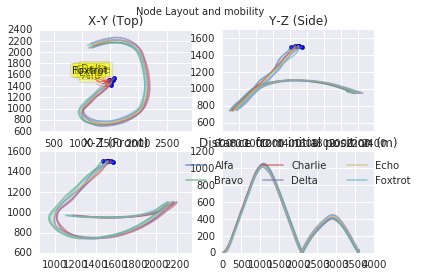

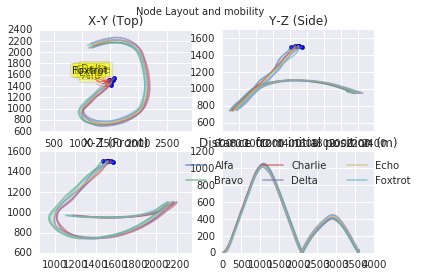

In [329]:
from bounos.ChartBuilders import plot_axes_views_from_positions_frame

plot_axes_views_from_positions_frame(positions.xs('Waypoint', level='var'))


In [323]:
dtrace = node_p.apply(np.linalg.norm, axis=1) - np.linalg.norm(node_p.iloc[0])
dtrace.values.T

array([  0.000e+00,  -8.427e-03,  -2.539e-02, ...,  -6.643e+01,
        -6.670e+01,  -6.696e+01])

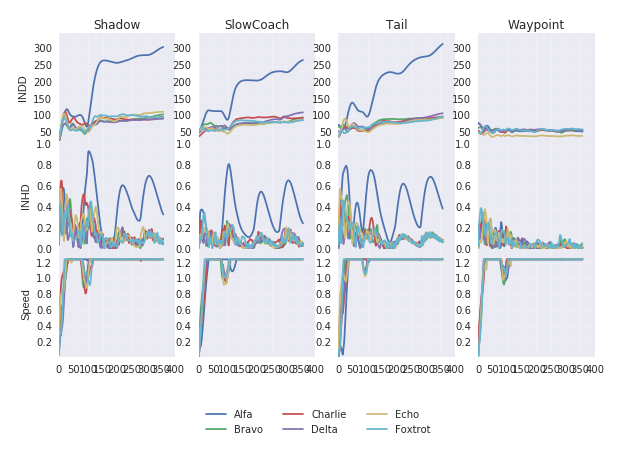

In [350]:
def plot_behaviour_metric_graph(data, observer = 'Bravo', run = 0, force_ymin=None):
    from matplotlib.gridspec import GridSpec

    _bevs = set(data.index.get_level_values('var'))
    _metrics = list(data.columns)
    fig = plt.figure(figsize=(8, 6), dpi=80)
    base_ax = fig.add_axes([0, 0, 1, 1], )
    base_ax.set_axis_off()
    gs = GridSpec(len(_metrics), len(_bevs))
    axes = [[None for _ in range(len(_metrics))] for _ in range(len(_bevs))]
    # Column Behaviours
    for i, (behaviour, bev_df) in enumerate(data.groupby(level='var')):
        # Row Metrics
        metrics_df = bev_df
        if 'run' in bev_df.index.names:
            metrics_df = metrics_df.xs(run, level='run', drop_level=True)
        if 'observer' in bev_df.index.names:
            metrics_df = metrics_df.xs(observer, level='observer')
        for j, metric in enumerate(metrics_df):
            ax = fig.add_subplot(gs[j, i])
            for target, target_df in metrics_df[metric].groupby(level='target'):
                target_df.values
                ax.plot(target_df.values, label=target)
            if j == 0:
                ax.set_title(behaviour)
            ax.grid(True, alpha=0.2)
            ax.autoscale_view(scalex=False, tight=True)

            # Metric label on left most graph
            if i == 0:
                ax.set_ylabel(metric)

            #ax.legend()
            #
            # Last Metric Behaviour (Legend)
            if j == len(_metrics) - 1:
                if i == 0:
                    ax.legend(loc="lower center",
                              bbox_to_anchor=(0, 0, 1, 1),
                              bbox_transform=fig.transFigure,
                              ncol=3, frameon=False, prop={'size':10})
                else:
                    pass
            else:
                [l.set_visible(False) for l in ax.get_xticklabels()]
            axes[i][j] = ax
    # For each metric row
    for j in range(len(_metrics)):
        (m_ymin, m_ymax) = (float('inf'), float('-inf'))
        (m_xmin, m_xmax) = (float('inf'), float('-inf'))
        # Take the max limits across all behaviours
        for i in range(len(_bevs)):
            (ymin, ymax) = axes[i][j].get_ylim()
            (xmin, xmax) = axes[i][j].get_xlim()
            m_ymax = max(ymax, m_ymax)
            m_ymin = min(ymin, m_ymin)
            m_xmax = max(xmax, m_xmax)
            m_xmin = min(xmin, m_xmin)
        
        m_ymin = m_ymin if force_ymin is None else force_ymin
        # Reset the rows limits
        for i in range(len(_bevs)):
            axes[i][j].set_ylim((m_ymin*0.9, m_ymax * 1.1))
            axes[i][j].set_xlim((0, m_xmax))
        
    fig.subplots_adjust(
            left=0.05, bottom=0.2, right=0.98, top=0.95, wspace=0.2, hspace=0.0)

    fig.show()

    return fig
fig = plot_behaviour_metric_graph(trust_observations)

In [287]:
trust_observations.head()

metric                              INDD      INHD     Speed
var    run observer t target                                
Shadow 0   Alfa     1 Alfa     28.070365  0.096864  0.115341
                      Bravo    26.687243  0.074566  0.050705
                      Charlie  25.690930  0.086199  0.094040
                      Delta    28.245325  0.121883  0.124073
                      Echo     20.860398  0.040512  0.062482

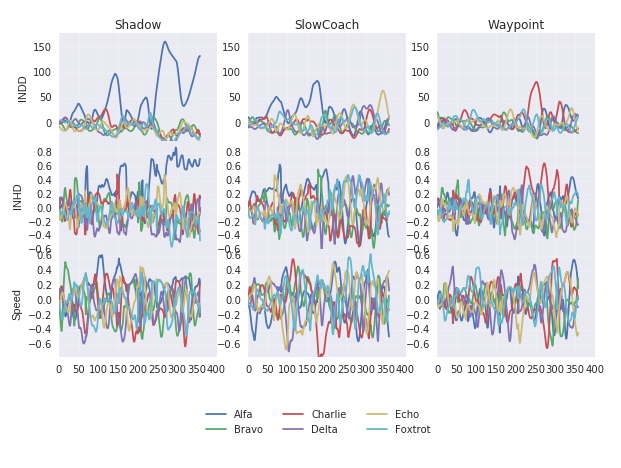

In [290]:
data = trust_observations.xs(observer, level='observer').xs(run, level='run')
deviance = pd.concat([gf-gf.mean()for g,gf in data.groupby(level=['var','t'])])
fig = plot_behaviour_metric_graph(deviance)

In [345]:
pd.concat([(gf).abs() for g,gf in deviance.groupby(level=['var','t'])]).head()

metric                INDD      INHD     Speed
var    t target                               
Shadow 1 Alfa     1.027808  0.015407  0.030890
         Bravo    0.355314  0.006891  0.033745
         Charlie  1.351627  0.004741  0.009589
         Delta    1.202768  0.040426  0.039623
         Echo     6.182159  0.040946  0.021969

In [343]:
pd.concat([(gf.std(axis=0)).abs() for g,gf in deviance.groupby(level=['var','t'])]).head()

metric
INDD     3.865078
INHD     0.027497
Speed    0.031088
INDD     4.030194
INHD     0.071647
dtype: float64

In [346]:
pd.concat([(gf/(gf.std(axis=0)/2)).abs() for g,gf in deviance.groupby(level=['var','t'])]).head()

metric                INDD      INHD     Speed
var    t target                               
Shadow 1 Alfa     0.531843  1.120639  1.987280
         Bravo    0.183859  0.501220  2.170988
         Charlie  0.699405  0.344851  0.616896
         Delta    0.622377  2.940391  2.549092
         Echo     3.198982  2.978228  1.413360

In [347]:
pd.concat([(gf/(gf.std(axis=0))).abs() for g,gf in deviance.groupby(level=['var','t'])]).head()

metric                INDD      INHD     Speed
var    t target                               
Shadow 1 Alfa     0.265922  0.560320  0.993640
         Bravo    0.091929  0.250610  1.085494
         Charlie  0.349702  0.172426  0.308448
         Delta    0.311189  1.470196  1.274546
         Echo     1.599491  1.489114  0.706680

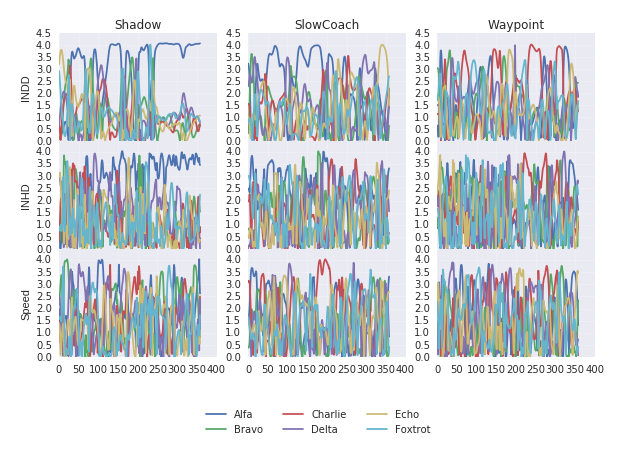

In [348]:
fig = plot_behaviour_metric_graph(pd.concat([(gf/(gf.std(axis=0)/2)).abs() for g,gf in deviance.groupby(level=['var','t'])]))


In [280]:
deviance = pd.concat([gf-gf.std(axis=1)for g,gf in data.groupby(level=['var','t'])])
#deviance.std(axis=1)
deviance.unstack('metric').stack('target').head()
fig = plot_behaviour_metric_graph(deviance.unstack('metric').stack('target'))

ValueError: cannot join with no level specified and no overlapping names

In [267]:
pd.concat([gf.std(axis=1) for g,gf in deviance.stack('metric').unstack('target').groupby(level=['var','t'])])

var       t    metric
Shadow    1    INDD       3.865078
               INHD       0.027497
               Speed      0.031088
          2    INDD       4.030194
               INHD       0.071647
               Speed      0.083160
          3    INDD       4.344301
               INHD       0.099999
               Speed      0.120612
          4    INDD       4.775231
               INHD       0.113893
               Speed      0.150675
          5    INDD       5.257735
               INHD       0.115398
               Speed      0.179217
          6    INDD       5.757386
               INHD       0.118566
               Speed      0.213212
          7    INDD       6.265011
               INHD       0.125318
               Speed      0.243495
          8    INDD       6.786922
               INHD       0.132483
               Speed      0.245725
          9    INDD       7.310967
               INHD       0.139897
               Speed      0.211502
          10   INDD       7.84753

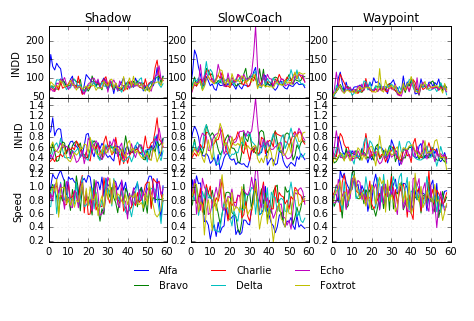

In [250]:
fig_600

Alfa
Bravo
Charlie
Delta
Echo
Foxtrot


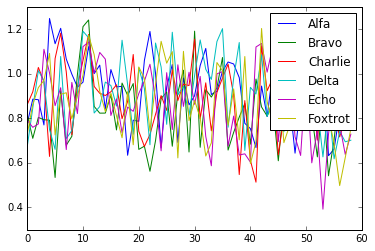

In [73]:
for target, target_df in metrics_df[metric].groupby(level='target'):
    print target
    plt.plot(target_df.values, label=target)
plt.legend()

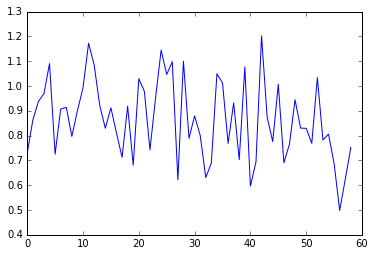

In [70]:
from matplotlib import pylab as plt
plt.plot(target_df.values)

In [94]:
metrics_df.unstack('target').stack().as_matrix()[0,:]
deviance = metrics_df-metrics_df.groupby(level=['var']).apply(np.mean, axis=0)
deviance.std(axis=1).head()


var       t  target 
Waypoint  1  Alfa       10.931509
             Bravo      12.341216
             Charlie    15.811806
             Delta      12.118861
             Echo       13.405424
dtype: float64

In [102]:
deviance.groupby(level='target').mean()

,INDD,INHD,Speed
target,,,
Alfa,5.228373,0.004306,0.043817
Bravo,-1.053045,-0.031529,-0.050369
Charlie,-1.352770,0.022393,0.011455
Delta,-0.501435,0.012146,0.025211
Echo,-1.294641,-0.016498,-0.017055
Foxtrot,-1.026482,0.009182,-0.013059


In [103]:
metrics_df

INDD      INHD     Speed
var      t  target                                 
Waypoint 1  Alfa      54.731743  0.325739  0.775881
            Bravo     52.342929  0.391801  0.815651
            Charlie   46.310339  0.303472  0.860593
            Delta     52.621357  0.322391  0.671606
            Echo      50.448837  0.314564  0.791046
            Foxtrot   50.492998  0.266297  0.727580
         2  Alfa      56.762001  0.402809  0.885302
            Bravo     59.731078  0.300238  0.709745
            Charlie   54.988406  0.475705  0.918082
            Delta     51.947023  0.417602  0.845850
            Echo      69.510130  0.612911  0.759155
            Foxtrot   59.478915  0.412247  0.862015
         3  Alfa      62.737380  0.424032  0.882851
            Bravo     63.767673  0.327990  0.803456
            Charlie   71.514178  0.421659  1.027422
            Delta     80.248158  0.582589  1.013364
            Echo     115.745870  0.914177  0.774228
            Foxtrot   63.316312  0.350543  0.937216
         4  Alfa      99.990415  0.800024  0.769718
            Bravo     70.428725  0.398036  0.793041
            Charlie   76.757211  0.652243  0.963110
            Delta     72.711807  0.588278  0.966070
            Echo      80.422655  0.671409  1.108684
            Foxtrot   73.565365  0.431984  0.969285
         5  Alfa     115.751474  0.698440  1.246719
            Bravo     82.890400  0.496991  0.791247
            Charlie  110.393537  0.863111  0.628708
            Delta     76.821243  0.403113  0.749148
            Echo      73.518234  0.406273  1.002880
            Foxtrot   80.083139  0.477449  1.090348
...                         ...       ...       ...
         55 Alfa      97.574387  0.360717  0.632065
            Bravo     73.198518  0.346860  0.542051
            Charlie   67.297541  0.407320  0.899858
            Delta     73.388964  0.396708  0.859098
            Echo      68.713339  0.435630  0.728865
            Foxtrot   75.398586  0.575681  0.806057
         56 Alfa      73.067402  0.325211  0.661643
            Bravo     87.068616  0.409670  0.703622
            Charlie   76.825071  0.438159  0.830421
            Delta     87.234260  0.615052  0.617950
            Echo      71.896904  0.478994  0.927326
            Foxtrot   72.797857  0.403123  0.687483
         57 Alfa      70.492597  0.378505  0.825380
            Bravo     66.613274  0.363235  0.931372
            Charlie   73.868503  0.396319  0.716194
            Delta     75.517278  0.476921  0.741178
            Echo      72.885721  0.430514  0.770911
            Foxtrot   59.766687  0.406855  0.498055
         58 Alfa      82.553627  0.497792  0.933029
            Bravo     80.715645  0.318071  0.768087
            Charlie   76.354461  0.453670  0.804371
            Delta     75.800917  0.398704  0.694369
            Echo      70.871885  0.464602  0.637662
            Foxtrot   85.684450  0.403607  0.623810
         59 Alfa      73.746942  0.368007  0.940411
            Bravo     75.240616  0.411951  0.845872
            Charlie   70.021631  0.389284  0.910078
            Delta     55.473107  0.292934  0.701358
            Echo      63.377700  0.316554  0.728375
            Foxtrot   68.091185  0.173878  0.752387

[354 rows x 3 columns]